<a href="https://colab.research.google.com/github/seyonechithrananda/bert-loves-chemistry/blob/master/HuggingFace_DeepChem_final_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Part 21: Finetuning HuggingFace's RoBERTa for masked language modelling of SMILES

![alt text](https://huggingface.co/front/assets/huggingface_mask.svg)

By Seyone Chithrananda

Deep learning for chemistry and materials science remains a novel field with lots of potiential. However, the popularity of transfer learning based methods in areas such as NLP and computer vision have not yet been effectively developed in computational chemistry + machine learning. Using HuggingFace's suite of models and the ByteLevel tokenizer, we are able to train a large-transformer model, RoBERTa, on a large corpus of 100k SMILES strings from a commonly known benchmark chemistry dataset, ZINC.

Training RoBERTa over 5 epochs, the model achieves a pretty good loss of 0.398, and may likely continue to decrease if trained for a larger number of epochs. The model can predict tokens within a SMILES sequence/molecule, allowing for variants of a molecule within discoverable chemical space to be predicted.

By applying the representations of functional groups and atoms learned by the model, we can try to tackle problems of toxicity, solubility, drug-likeness, and synthesis accessibility on smaller datasets using the learned representations as features for graph convolution and attention models on the graph structure of molecules, as well as fine-tuning of BERT. Finally, we propose the use of attention visualization as a helpful tool for chemistry practitioners and students to quickly identify important substructures in various chemical properties.

Additionally, visualization of the attention mechanism have been seen through previous research as incredibly valuable towards chemical reaction classification. The applications of open-sourcing large-scale transformer models such as RoBERTa with HuggingFace may allow for the acceleration of these individual research directions.

A link to a repository which includes the training, uploading and evaluation notebook (with sample predictions on compounds such as Remdesivir) can be found [here](https://github.com/seyonechithrananda/bert-loves-chemistry). All of the notebooks can be copied into a new Colab runtime for easy execution.

For the sake of this tutorial, we'll be fine-tuning RoBERTa on a small-scale molecule dataset, to show the potiential and effectiveness of HuggingFace's NLP-based transfer learning applied to computational chemistry.

Installing DeepChem from source, alongside RDKit for molecule visualizations

In [1]:
import tensorflow as tf
print("tf.__version__: %s" % str(tf.__version__))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.__version__: 2.2.0-rc3
Found GPU at: /device:GPU:0


In [2]:
!pip install transformers


     |████████████████████████████████| 573kB 12.3MB/s 
     |████████████████████████████████| 3.7MB 47.4MB/s 
     |████████████████████████████████| 1.0MB 27.1MB/s 
     |████████████████████████████████| 890kB 55.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=49159e7f355e0b67097229550cdd83f0d2fdb44567a06534b35c19bfedadfcc3
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


Now, to ensure our model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for Remdesivir.

In [3]:
from transformers import AutoModelWithLMHead, AutoTokenizer, pipeline

model = AutoModelWithLMHead.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)


In [4]:
remdesivir_mask = "CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=<mask>1"
remdesivir = "CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1"

"CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=O1"

masked_smi = fill_mask(remdesivir_mask)

for smi in masked_smi:
  print(smi)

{'sequence': '<s> CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1</s>', 'score': 0.5986586809158325, 'token': 39}
{'sequence': '<s> CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=O1</s>', 'score': 0.09766950458288193, 'token': 51}
{'sequence': '<s> CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=N1</s>', 'score': 0.07694468647241592, 'token': 50}
{'sequence': '<s> CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=21</s>', 'score': 0.0241263248026371, 'token': 22}
{'sequence': '<s> CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=H1</s>', 'score': 0.0188530795276165, 'token': 44}


Here, we get some interesting results. The final branch, `C1=CC=CC=C1`, is a  benzene ring. Since its a pretty common molecule, the model is easily able to predict the final double carbon bond with a score of 0.60. Let's get a list of the top 5 predictions (including the target, Remdesivir), and visualize them (with a highlighted focus on the beginning of the final benzene-like pattern). Lets import some various RDKit packages to do so.


In [5]:
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-04-24 04:23:25--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M  55.6MB/s    in 1.5s    

2020-04-24 04:23:27 (55.6 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
 

In [0]:
import torch
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage
from PIL import Image


def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol


def find_matches_one(mol,submol):
    #find all matching atoms for each submol in submol_list in mol.
    match_dict = {}
    mols = [mol,submol] #pairwise search
    res=rdFMCS.FindMCS(mols) #,ringMatchesRingOnly=True)
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches

#Draw the molecule
def get_image(mol,atomset):    
    hcolor = colors.to_rgb('green')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img

In [7]:
sequence = f"CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC={tokenizer.mask_token}1"
substructure = "CC=CC"
image_list = []

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

token_logits = model(input)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
  smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
  print (smi)
  smi_mol = get_mol(smi)
  substructure_mol = get_mol(substructure)
  if smi_mol is None: # if the model's token prediction isn't chemically feasible
    continue
  Draw.MolToFile(smi_mol, smi+".png")
  matches = find_matches_one(smi_mol, substructure_mol)
  atomset = list(matches[0])
  img = get_image(smi_mol, atomset)
  img.format="PNG" 
  image_list.append(img)

CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1
CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=O1
CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=N1
CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=21
CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=H1


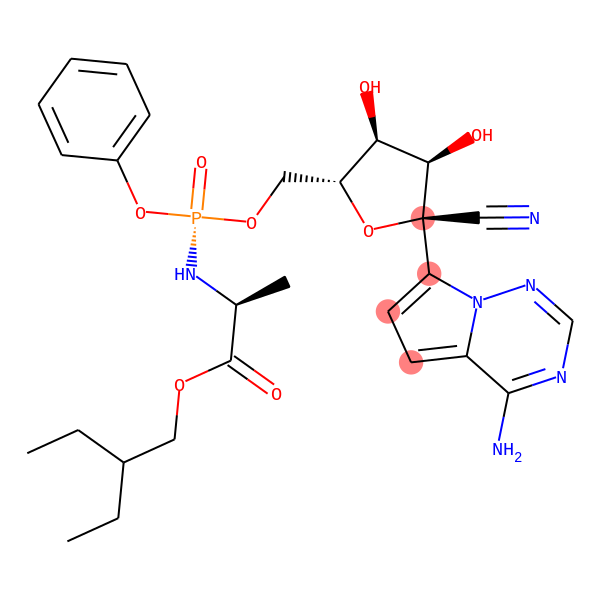

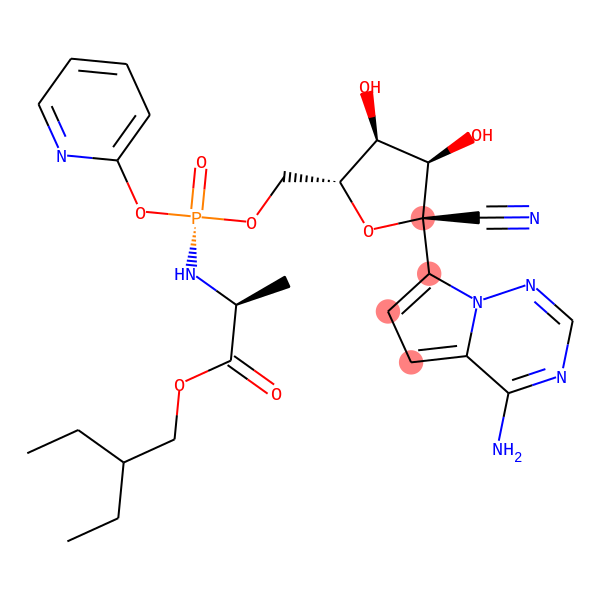

In [8]:
from IPython.display import Image 

for img in image_list:
  display(img)

As we can see above, 2 of 4 of the model's MLM predictions are chemically valid. The one the model would've chosen (with a score of 0.6), is the first image, in which the top left molecular structure resembles the benzene found in the therapy Remdesivir. Overall, the model seems to understand syntax with a pretty decent degree of certainity. 

However, further training on a more specific dataset (say leads for a specific target) may generate a stronger MLM model. Let's now fine-tune our model on a dataset of our choice, Tox21.

# Fine-tuning ChemBERTa on a Small Mollecular Dataset

Tumor suppressor protein (SR.p53), typically the p53 pathway is “off” and is activated when cells are under stress or damaged, hence being a good indicator of DNA damage and other cellular stresses. Tumor suppressor protein p53 is activated by inducing DNA repair, cell cycle arrest and apoptosis.

The Tox21 challenge was introduced in 2014 in an attempt to build models that are successful in predicting compounds' interference in biochemical pathways using only chemical structure data. The computational models produced from the challenge could become decision-making tools for government agencies in determining which environmental chemicals and drugs are of the greatest potential concern to human health. Additionally, these models can act as drug screening tools in the drug discovery pipelines for toxicity.

Lets start by loading the dataset from s3, before importing apex and transformers, the tool which will allow us to import the pre-trained masked-language modelling architecture trained on ZINC15.

In [1]:
!wget https://t.co/zrC7F8DcRs?amp=1

--2020-04-24 04:31:11--  https://t.co/zrC7F8DcRs?amp=1
Resolving t.co (t.co)... 104.244.42.5, 104.244.42.133, 104.244.42.69, ...
Connecting to t.co (t.co)|104.244.42.5|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21_balanced_revised_no_id.csv [following]
--2020-04-24 04:31:12--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21_balanced_revised_no_id.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.112.193
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.112.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85962 (84K) [text/csv]
Saving to: ‘zrC7F8DcRs?amp=1’

zrC7F8DcRs?amp=1    100%[===================>]  83.95K   231KB/s    in 0.4s    

2020-04-24 04:31:13 (231 KB/s) - ‘zrC7F8DcRs?amp=1’ saved [85962/85962]



We want to install NVIDIA's Apex tool, for the training pipeline used by `simple-transformer` and Weights and Biases.

In [2]:
!git clone https://github.com/NVIDIA/apex
!cd /content/apex
!pip install -v --no-cache-dir /content/apex
!cd ..

Cloning into 'apex'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6593 (delta 0), reused 0 (delta 0), pack-reused 6589
Receiving objects: 100% (6593/6593), 13.70 MiB | 1.52 MiB/s, done.
Resolving deltas: 100% (4383/4383), done.
Created temporary directory: /tmp/pip-ephem-wheel-cache-q5nbg4uh
Created temporary directory: /tmp/pip-req-tracker-ixo7f527
Created requirements tracker '/tmp/pip-req-tracker-ixo7f527'
Created temporary directory: /tmp/pip-install-4bvkod3b
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-nltce4xy
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-ixo7f527'
    Running setup.py (path:/tmp/pip-req-build-nltce4xy/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info
    torch.__version__  =  1.4.0
    running egg_info
    creating /tmp/pip-req-build-nltce4xy/pip-egg-info/apex.egg-info

In [0]:
# Test if NVIDIA apex training tool works
from apex import amp

If you're only running the toxicity prediction portion of this tutorial, make sure you install transformers here. If you've ran all the cells before, you can ignore this install as we've already done `pip install transformers` before.

In [4]:
!pip install transformers

     |████████████████████████████████| 573kB 33.4MB/s 
     |████████████████████████████████| 3.7MB 59.5MB/s 
     |████████████████████████████████| 1.0MB 54.3MB/s 
     |████████████████████████████████| 890kB 52.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=5debc70bf2760c36e513997d6cfe94649592d95dd3b9654ec526cd2a32cad0f2
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [5]:
!pip install simpletransformers
!pip install wandb

     |████████████████████████████████| 163kB 15.8MB/s 
     |████████████████████████████████| 204kB 26.6MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=9e0590e9e861f1347cbf412dcdb58e84cd910ed9897342f135f0caf8b102ccab
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
     |████████████████████████████████| 1.4MB 22.0MB/s 
     |████████████████████████████████| 112kB 49.4MB/s 
     |████████████████████████████████| 460kB 55.5MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=88d395f05da00e481a02baafbdb85210b0ac9c1ebd46282674b22ba931f49b49
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655

From here, we want to load the dataset from tox21 for training the model. We're going to use a filtered dataset of 2100 compounds, as there are only 400 positive leads and we want to avoid having a large data imbalance. We'll also use simple-transformer's `auto_weights` argument in defining our ChemBERTa model to do automatic weight balancing later on, to counteract this problem.



In [7]:
!cd ..
dataset_path = "/content/zrC7F8DcRs?amp=1"
df = pd.read_csv(dataset_path, sep = ',', warn_bad_lines=True, header=None)


df.rename(columns={0:'smiles',1:'labels'}, inplace=True)
df.head()

,smiles,labels
0,CCCCCCCC/C=C\CCCCCCCC(N)=O,0
1,CCCCCCOC(=O)c1ccccc1,0
2,O=C(c1ccc(Cl)cc1)c1ccc(Cl)cc1,0
3,COc1cc(Cl)c(OC)cc1N,0
4,N[C@H](Cc1c[nH]c2ccccc12)C(=O)O,0


From here, lets set up a logger to record if any issues occur, and notify us if there are any problems with the arguments we've set for the model. 

In [0]:
from simpletransformers.classification import ClassificationModel
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Now, using `simple-transformer`, let's load the pre-trained model from HuggingFace's useful model-hub. We'll set the number of epochs to 3 in the arguments, but you can train for longer. Also make sure that `auto_weights` is set to True as we are dealing with imbalanced toxicity datasets.

In [0]:
model = ClassificationModel('roberta', 'seyonec/ChemBERTa-zinc-base-v1', args={'num_train_epochs': 3, 'auto_weights': True}) # You can set class weights by using the optional weight argument


In [0]:
# Split the train and test dataset 80-20

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200).reset_index(drop=True)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)

In [11]:
# check if our train and evaluation dataframes are setup properly. There should only be two columns for the SMILES string and its corresponding label.

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (2142, 2)
TRAIN Dataset: (1714, 2)
TEST Dataset: (428, 2)


Now that we've set everything up, lets get to the fun part: training the model! We use Weights and Biases, which is optional (simply remove `wandb_project` from the list of args). Its a really useful tool for monitering the model's training results (such as accuracy, learning rate and loss), alongside with custom visualizations you can create as well as the gradients. 

When you run this cell, Weights and Biases will ask for an account, which you can setup when you get a key through a Github account. Again, this is completely optional and it can be removed from the list of arguments.

In [14]:
# Create directory to store model weights (change path accordingly to where you want!)
!cd /content
!mkdir chemberta_tox21

# Train the model
model.train_model(train_dataset, output_dir='/content/chemberta_tox21', num_labels=2, use_cuda=True, args={'wandb_project': 'project-name'})


mkdir: cannot create directory ‘chemberta_tox21’: File exists


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:243: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:wandb.run_manager:system metrics and metadata threads started
INFO:wandb.run_manager:checking resume status, waiting at most 10 seconds
INFO:wandb.run_manager:resuming run from id: UnVuOnYxOjEyMGVtb2htOnByb2plY3QtbmFtZTpzZXlvbmVj
INFO:wandb.run_manager:upserting run before process can begin, waiting at most 10 seconds
INFO:wandb.run_manager:saving patches
INFO:wandb.run_manager:saving pip packages
INFO:wandb.run_manager:initializing streaming files api
INFO:wandb.run_manager:unblocking file change observer, beginning sync with W&B servers


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:113: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/config.yaml


Running loss: 0.788242

INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200424_043823-120emohm/wandb-metadata.json
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200424_043823-120emohm/media/graph/graph_0_summary_0fce41b2.graph.json
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200424_043823-120emohm/wandb-events.jsonl
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200424_043823-120emohm/requirements.txt
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200424_043823-120emohm/media/graph
INFO:wandb.run_manager:file/dir created: /content/wandb/run-20200424_043823-120emohm/media


Running loss: 0.511236

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.602639

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.232389

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.853039

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-events.jsonl


Running loss: 0.501909

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-metadata.json
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.066326


Running loss: 0.170885

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.221705

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-metadata.json


Running loss: 0.207991

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.173742

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.456498

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-events.jsonl


Running loss: 1.234981

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-metadata.json


Running loss: 0.397285

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.094101


Running loss: 0.043023

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.053245

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-metadata.json


Running loss: 0.175583

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.182486

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-events.jsonl


Running loss: 0.071419

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.565325

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-metadata.json


Running loss: 0.601075

INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-history.jsonl
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-summary.json


Running loss: 0.970592



INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to /content/chemberta_tox21.
INFO:wandb.run_manager:shutting down system stats and metadata service
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-events.jsonl
INFO:wandb.run_manager:stopping streaming files and file change observer
INFO:wandb.run_manager:file/dir modified: /content/wandb/run-20200424_043823-120emohm/wandb-metadata.json


Let's install scikit-learn now, to evaluate the model we've trained.

In [15]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)


The following cell can be ignored unless you are starting a new run-time and just want to load the model from your local directory.

In [0]:
# Loading a saved model for evaluation
model = ClassificationModel('roberta', '/content/chemberta_tox21', num_labels=2, use_cuda=True, args={'wandb_project': 'project-name','num_train_epochs': 3})

In [16]:
import sklearn
result, model_outputs, wrong_predictions = model.eval_model(test_dataset, acc=sklearn.metrics.accuracy_score)


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:660: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.7136017700095658, 'tp': 55, 'tn': 335, 'fp': 4, 'fn': 34, 'acc': 0.9112149532710281, 'eval_loss': 0.2323251810890657}


The model performs pretty well, averaging above 91% after training on only ~2000 data samples and 400 positive leads! We can clearly see the predictive power of transfer learning, and approaches like these are becoming increasing popular in the pharmaceutical industry where larger datasets are scarce. By training on more epochs and tasks, we can probably boost the accuracy as well!

Lets train the model on one last string outside of the filtered dataset for toxicity. The model should predict 0, meaning no interference in biochemical pathways for p53.

In [17]:
# Lets input a molecule with a SR-p53 value of 0
predictions, raw_outputs = model.predict(['CCCCOc1cc(C(=O)OCCN(CC)CC)ccc1N'])


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [18]:
print(predictions)
print(raw_outputs)

[0]
[[ 2.9023438 -2.859375 ]]


The model predicts the sample correctly! Some future tasks may include using the same model on multiple tasks (Tox21 provides multiple for toxicity), through multi-task classification, as well as training on a wider dataset. This will be expanded on in a future tutorial!